In [1]:
%load_ext autoreload
%pylab inline

import sys
import pandas as pd
import xarray as xr
import seaborn
from cartopy import crs, feature
from warnings import filterwarnings

seaborn.set_palette('tab20')
filterwarnings('ignore', category=RuntimeWarning)
%autoreload 2

sys.path.insert(0, '..')
# import the scripts package as reccap2ocean : r2o
import scripts as r2o

Populating the interactive namespace from numpy and matplotlib


# Import data using YAML file

Note that this should work on any machine as long as you have the requirements installed. Files will be downloaded to the 

In [2]:
cat = r2o.data.read_catalog('../scripts/data/reccap2_data.yml')

In [24]:
# # read SOCAT data from the website
socat = r2o.data.socat2020(cat['socat_pco2'], verbose=False)
liar2 = r2o.data.soccom_float_liar(cat['soccom_liar'], verbose=False)

# reads mask data from the RECCAP website
mask = r2o.data.southern_ocean_mask()
subs = mask.subregions
so = r2o.plot.extend_lon_for_contour_plots(subs)

..............................................................................................................................................................................................

In [4]:
# read reccap data from the FTP site
# the output of reccap_surface_CO2 is a special object that I wrote some code for
# it contains all the netCDF files in the surface CO2 folder split by variable and then data provider
# this can be browsed interactively to see what is in the folder
# There are some faulty files on the server. I ran the script, updated the cache file and then ran it again. 
surface_co2 = r2o.data.reccap_surface_CO2(cat['surface_co2'], verbose=False, use_cache=True)

# MANUAL HACK
# CSIR and NIES have their fluxes -ve downward, change to +ve
for product in ['CSIR', 'NIES']:
    for key in ['fgco2', 'fgco2_glob', 'fgco2_reg']:
        if hasattr(surface_co2[key], product):
            surface_co2[key][product] = -surface_co2[key][product].load()

In [5]:
# the object can be used to quickly check the data entries for each variable. 
# note that some of the variables have been renamed based on input arguements.
# the unmatched file names are files that do not meet the matching requirements
surface_co2

<class 'scripts.data.main._RECCAP_dict'>
  Kw -------------------------------------------------------------------------- 
    CMEMS      [UNITS] m/s                   [DIMS] lon(360).lat(180).time(408)
    CSIR       [UNITS] m/s                   [DIMS] lon(360).lat(180).time(408)
    NIES       [UNITS] mol m-2 s-1           [DIMS] lon(360).lat(180).time(408)
    UOEX       [UNITS] m s-1                 [DIMS] lon(360).lat(180).time(408)
  
  alpha ----------------------------------------------------------------------- 
    CMEMS      [UNITS] mol/m3/uatm           [DIMS] lon(360).lat(180).time(408)
    CSIR       [UNITS] mol/m3/uatm           [DIMS] lon(360).lat(180).time(408)
    NIES       [UNITS] mol kg-1 atm-1        [DIMS] lon(360).lat(180).time(408)
  
  alpha_skin ------------------------------------------------------------------ 
    UOEX       [UNITS] mol m-3 microatm-1    [DIMS] lon(360).lat(180).time(408)
  
  alpha_subskin ---------------------------------------------------

# Regional integrated fluxes

### Calculate fluxes for each region

I highly recommend first calculating the fluxes for each region and only then plot

In [6]:
# molC/m2/s -- > gC/m2/yr        s/day . day/yr . g/mol
flux = surface_co2.fgco2.data() * 86400 * 365 * 12.011
area = flux.area()  # a special function from scripts.analysis.area.py

flux_regions = []
for r in range(1, 10):
    rf = flux.where(subs == r)
    flux_regions += (-rf * area).sum(['lat', 'lon']).compute() * 1e-15,

### Plot fluxes for each region

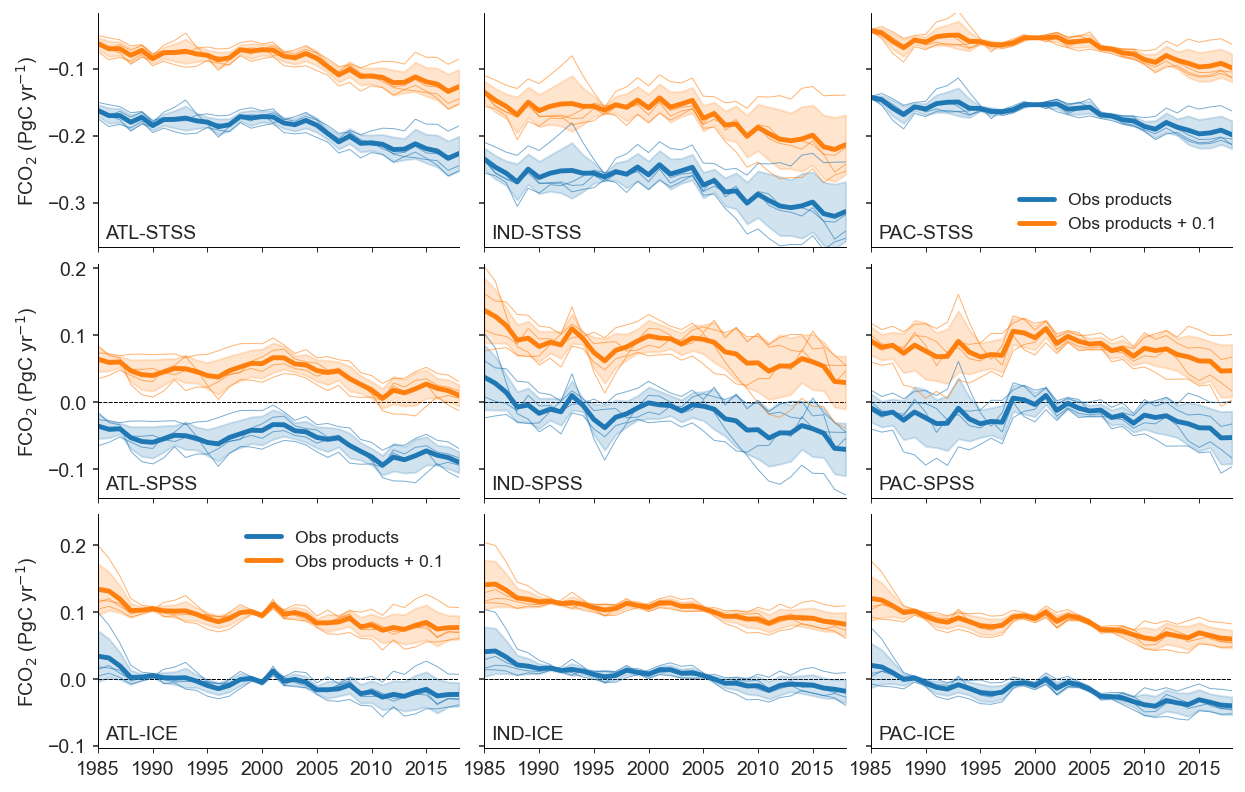

In [34]:
fig, ax = plt.subplots(3, 3, figsize=[9, 6], dpi=140, sharex='all', sharey='row')
# first transpose to draw plots columnwise to match [ATL, IND, PAC] columns
ax = ax.T.reshape(-1) 

for i, df in enumerate(flux_regions):    
    # resample the data to annual - could also smooth data instead
    df = df.resample(time='1AS').mean()
    
    # plot using premade function. Takes an ensemble and will plot the
    # ensemble members, mean of ensemble, stdev of ensemble (optional)
    r2o.plot.plot_ensemble_lines(df, ax=ax[i], name='Obs products', color='C0')
    # second dataset added as example
    r2o.plot.plot_ensemble_lines(df + 0.1, ax=ax[i], name='Obs products + 0.1', color='C1')
    
    # add a label of the data on the bottom left of each ax
    name = mask.names.isel(idx=i).values
    ax[i].text(0.02, 0.02, name, va='bottom', ha='left', transform=ax[i].transAxes)

# conform plots to style:
#   draws y=0 line if in within plot range, 
#   sets xticks to every 5 years
#   set the y_range to a fixed amount, centered around the existing y limits
[r2o.plot.style_line_subplot(a, xlim=a.get_xlim(), y_range=0.35) for a in ax]

# only left subplot labels
[a.set_ylabel('FCO$_2$ (PgC yr$^{-1}$)') for a in ax[:3]]

# only the mean of the ensemble is given a label so we can use ax.legend
ax[2].legend(loc='upper right', fontsize=9)
ax[6].legend(loc='lower right', fontsize=9)

plt.show()

# Maps 

### Plot with different colorbars

In [20]:
avg = -flux.mean(['variable', 'time']).T.compute()
std = flux.std('variable').mean('time').T.compute()

# extend the data for contour plots so that lon 0:361 to remove the gap in the plots
avg, std = [r2o.plot.extend_lon_for_contour_plots(a) for a in [avg, std]]

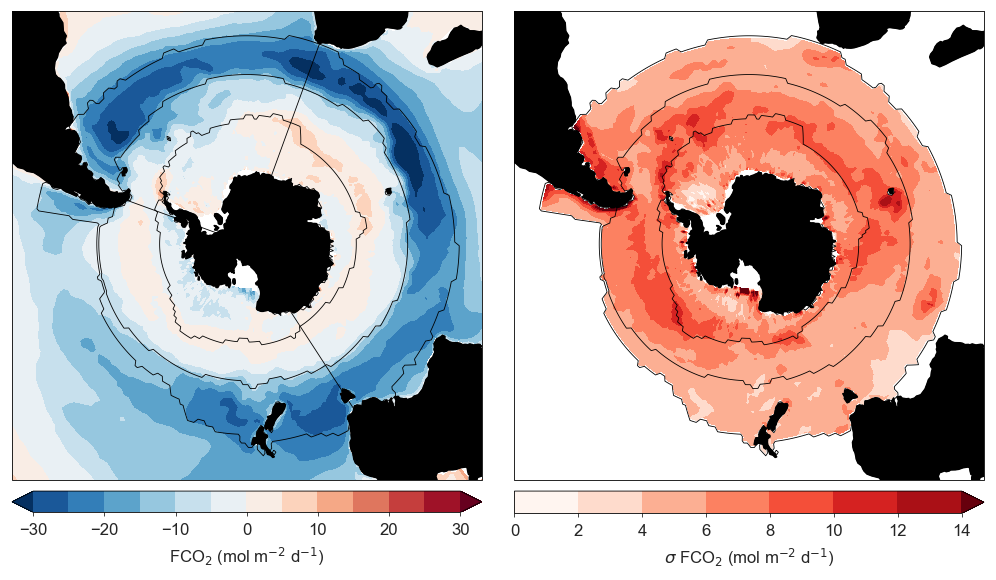

In [25]:
fig = plt.figure(figsize=[9, 5.5])

ax = [
    r2o.plot.subplot_map(121, round=False, proj=crs.SouthPolarStereo(), land_color='k'),
    r2o.plot.subplot_map(122, round=False, proj=crs.SouthPolarStereo(), land_color='k')]

props = dict(transform=crs.PlateCarree(), robust=True, cbar_kwargs=dict(orientation='horizontal', pad=0.02,))
# I've created a cm scheme for fluxes, pco2, temperature. Would be good to discuss this a bit more
img = [ # outputs need to be saved so that we can access the colorbar in the next step
    avg.plot.contourf(ax=ax[0], levels=np.arange(-30, 31, 5), cmap=r2o.plot.cm.flux, **props),
    # in the second option, I mask out the region outside of the SO. Also something to discuss. 
    std.where(so).plot.contourf(ax=ax[1], levels=np.arange(  0, 15, 2), cmap=r2o.plot.cm.flux_std, **props)]

# colorbar label
img[0].colorbar.set_label('FCO$_2$ (mol m$^{-2}$ d$^{-1}$)')
img[1].colorbar.set_label('$\sigma$ FCO$_2$ (mol m$^{-2}$ d$^{-1}$)')

# script will automatically download the data from the RECCAP website and plot on the given axes
# will also set the extent of the plot to -90 : -30
# basin lines can be switched off by setting it to []
r2o.plot.add_southern_ocean_subregion_contours(ax[0])
r2o.plot.add_southern_ocean_subregion_contours(ax[1], basin_lines=[])

### Plots with same colorbar

In [14]:
seasonal = r2o.plot.extend_lon_for_contour_plots(-flux.groupby('time.season').mean('time').compute().mean('variable').T)

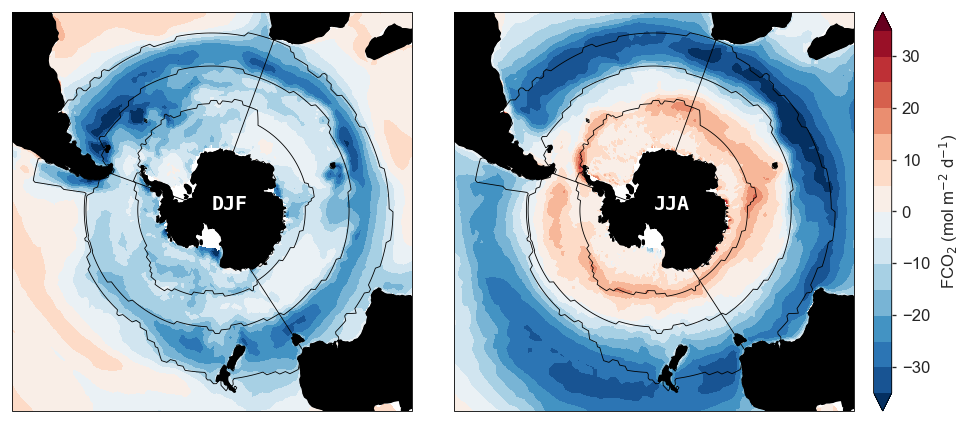

In [15]:
fig = plt.figure(figsize=[9, 3.8])

ax = [
    r2o.plot.subplot_map(121, round=False, proj=crs.SouthPolarStereo(), land_color='k'),
    r2o.plot.subplot_map(122, round=False, proj=crs.SouthPolarStereo(), land_color='k')]

props = dict(transform=crs.PlateCarree(), robust=True, add_colorbar=False, levels=np.arange(-35, 36, 5), cmap=r2o.plot.cm.flux)
img = [ # outputs need to be saved so that we can access the contour objects to create colorbars
    seasonal.sel(season='DJF').plot.contourf(ax=ax[0], **props),
    seasonal.sel(season='JJA').plot.contourf(ax=ax[1], **props)]

# colorbar created for both axes - then we can specify location
cb = plt.colorbar(mappable=img[0], ax=ax, location='right', pad=0.02, fraction=0.1)
cb.set_label('FCO$_2$ (mol m$^{-2}$ d$^{-1}$)')

props = dict(size=12, weight='bold', family='monospace', color='w', zorder=10, transform=crs.PlateCarree())
ax[0].text(0, -90, 'DJF', **props)
ax[1].text(0, -90, 'JJA', **props)

r2o.plot.add_southern_ocean_subregion_contours(ax[0])
r2o.plot.add_southern_ocean_subregion_contours(ax[1])